In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from dl import queryClient as qc
from astropy.table import Table, vstack
import utils
from collections import Counter

C:\Users\kylem\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import pdb

In [3]:
pltdir = 'results/plots'
if not os.path.exists(pltdir):
    os.makedirs(pltdir)

In [4]:
os.getcwd()

'D:\\msu\\RRLProject\\TempletFit'

In [5]:
gldrrab = np.loadtxt('goldsample/golden_RRab.txt',delimiter=',',dtype=str)
gldall  = np.loadtxt('goldsample/all_gold_sample.txt',dtype=str)
gldelse = np.array(list(set(gldall) - set(gldrrab)))

In [6]:
import RRLfit
tmps = Table.read('templates/layden_templates.fits',format='fits')['PH','RRA1','RRA2','RRA3','RRB1','RRB2','RRB3','RRC']
rrlfitter = RRLfit.RRLfitter(tmps,['u','g','r','i','z','Y','VR'],[1.4457, 1.4660, 1., 0.7833, 0.7467, 0.6696, 1.0507])
crvdat = RRLfit.get_data('93142_19513')#gldrrab[55])
plist = RRLfit.get_periods(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],objname='93142_19513')

In [8]:
RRLfit.fit_plot(rrlfitter,'93142_19513',verbose=True)

Get data
Get Periods
periods: [0.60527109 0.60626122 1.53992624 3.02633984 0.37666    0.37704804
 1.54645332 3.07997359 0.60429039 0.7533055 ]
First Fit
Initial Parameters:
t0: 56316.306785536
r amp: 0.6618695474888712
y offset: [16.683939 15.50688  15.666178 15.742703 15.764775 15.724058  0.      ]
Results: 
t0: 56316.226891370134
r amp: 0.6618696433771508
y offset: [16.6839389  15.50688962 15.66617588 15.74269915 15.76476718 15.72405436
  0.        ]
Period: 0.6052710862759998
Best Template: RRA2
Chi Square: 230798.13504351745
Outlier Rejection
Second Fit
Results: 
t0: 56316.24367848717
r amp: 0.6607506814535249
y offset: [16.67827962 15.56545995 15.66772451 15.72232146 15.70441241 15.64279018
  0.        ]
Period: 0.6052710862759998
Best Template: RRB1
Chi Square: 97819.9118026758
Start Plotting
Saved to results/plots/93142_19513_plot.png
Save parameters
Saved to results/93142_19513_res.fits
end


Text(0.5, 1.0, 'Template Fitter Normalized')

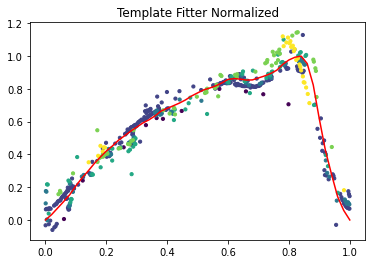

In [10]:
t0       = 56316.243641
ramp     = 0.660332
p        = 0.6052710862759998
yoffsets = np.array([16.67849976,15.56568743,15.66792606,15.72239278,15.68721446,15.6437937,0.])
amplist  = (ramp * rrlfitter.ampratio)[crvdat['fltr']]
yofflist = yoffsets[crvdat['fltr']]
plt.scatter((crvdat['mjd']-t0)/p%1,(crvdat['mag']-yofflist)/amplist,c=crvdat['fltr'],s=10)
plt.plot(tmps['PH'],tmps['RRB1'],c='r')
plt.title('Template Fitter Normalized')

- - -

In [11]:
import selftemplate
starid = '93142_19513'
cat = selftemplate.get_data(starid)
period = 0.60527109
bands,pars2,template,chisq = selftemplate.selftemplate(cat,period,verbose=True)

nbands = len(bands)
t0 = pars2[1]
amp = pars2[2:2+nbands]
mnmag = pars2[-nbands:]
ph = (cat['mjd'] - pars2[1]) / period %1
# sclmag = np.zeros(len(cat),float)
# for i,b in enumerate(bands):
#     ind, = np.where(cat['fltr']==b)
#     sclmag[ind] = (cat['mag'][ind]-mnmag[i])/amp[i]

C:\Users\kylem\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Niter =  0
Bands =  [0 1 2 3 4 5]
Amps =  [0.21760467 0.28457049 0.20672133 0.15855298 0.132752   0.12258517]
Mnmag =  [17.20101375 16.23752875 16.029173   16.01011125 16.0260335  15.971368  ]
phase min =  0.9200000000000002
shifting phase minimum by  -0.0800
RMS =  999999.0
Niter =  1
Bands =  [0 1 2 3 4 5]
Amps =  [ 0.82670697  0.77368583  0.09548936 -0.05487695 -0.17616462 -0.23665798]
Mnmag =  [16.62838473 15.60548296 15.92398733 16.09340217 16.16453181 16.07179308]
chisq =  2604130.6791877863
phase min =  0.0
RMS =  0.22869078584346705
Niter =  2
Bands =  [0 1 2 3 4 5]
Amps =  [ 0.67919083  0.84340205  0.45617973  0.13708996 -0.16739101 -0.29151738]
Mnmag =  [16.78594014 15.64898537 15.74548535 15.97168722 16.16795191 16.13367189]
chisq =  1498769.3028735493
phase min =  0.99
shifting phase minimum by  -0.0100
RMS =  0.2685301257702999
Niter =  3
Bands =  [0 1 2 3 4 5]
Amps =  [0.93408252 0.88928647 0.5958288  0.48524299 0.44409008 0.50133022]
Mnmag =  [16.58945308 15.59205139 15.

In [12]:
normags = selftemplate.scaledmags(cat,template,pars2)

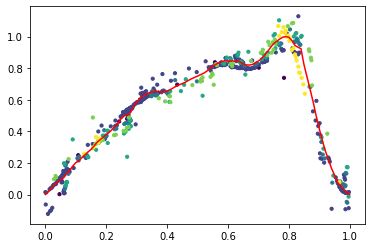

In [13]:
plt.scatter(ph,normags,c=cat['fltr'],s=10)
plt.plot(template['phase'],template['flux'],c='r')

----

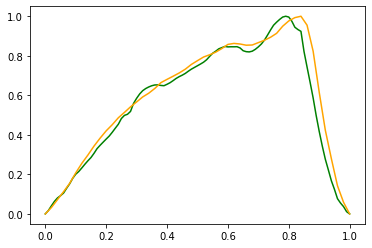

In [14]:
plt.plot(template['phase'],template['flux'],c='green')
plt.plot(tmps['PH'],tmps['RRB1'],c='orange')